## Extract Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/training data/Training and Validation Data_2023_T1_COMP3010.zip' -d training

In [ ]:
!unzip '/content/drive/MyDrive/training data/Testing Data_Dubai_2023.zip' -d test

In [4]:
!rmdir '/content/training/Data/coral image classification/train/.ipynb_checkpoints'

In [5]:
!rmdir '/content/training/Data/coral image classification/val/.ipynb_checkpoints'

## Load Libraries

In [1]:
## Python Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

## Neural Network
import torch as tr
import torchvision.datasets as datasets
from torchvision import models
import torchvision.transforms as trnsform
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from pylab import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Check Tourch Version

In [3]:
print("Using torch", tr.__version__)

Using torch 1.13.1+cu116


## Checking Cuda Support (GPU)

In [4]:
print(tr.cuda.device_count())
print(tr.cuda.get_device_name(0))

1
Tesla T4


#Assign cuda GPU located at location '0' to a variable


In [5]:
cuda0 = tr.device('cuda:0')
cuda0

device(type='cuda', index=0)

## Seed Settings

In [6]:
tr.cuda.manual_seed(1)
tr.backends.cudnn.deterministic = True
tr.backends.cudnn.benchmark = False

## Load Dataset

In [7]:
# ToTenssor, Convert Image into Pixel of Range [0,255] and images are normalized.
transform = trnsform.Compose([trnsform.Resize(255),trnsform.CenterCrop(224),trnsform.ToTensor()])

traindata = datasets.ImageFolder(root='/content/training/Data/coral image classification/train',transform=transform)
# Val Data
valdata = datasets.ImageFolder(root='/content/training/Data/coral image classification/val',transform=transform)
## Test Data
testdata = datasets.ImageFolder(root='/content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification',transform=transform)

## Train Data

* Train Data has 1117 Datapoints

In [8]:
traindata

Dataset ImageFolder
    Number of datapoints: 1117
    Root location: /content/training/Data/coral image classification/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Val Data

* Val Data has 400 Datapoints

In [14]:
valdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/training/Data/coral image classification/val
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Test Data

* Test Data has 400 Datapoints

In [15]:
testdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Classes of Dataset

In [16]:
classes=traindata.classes
classes

['Coral Images', 'Non-Coral Images']

## Loading Data From Images into Varaibles

In [9]:
X_trian = tr.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
X_test = tr.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)
X_val = tr.utils.data.DataLoader(valdata, batch_size=32, shuffle=True)

## Printing Batch and Labels size

In [18]:
batch, labels = next(iter(X_trian))

In [20]:
print("Batch size", batch.size()[0])
print("Image size", batch.size()[2],"x",batch.size()[3])
print("Image Channel", batch.size()[1])
print("Label size,", labels.size())

Batch size 32
Image size 224 x 224
Image Channel 3
Label size, torch.Size([32])


## Ploting Images

In [21]:
def functionlabel(label):
  if label == 1:
    return 'Coral Image'
  else:
    return 'Non-Coral Image'

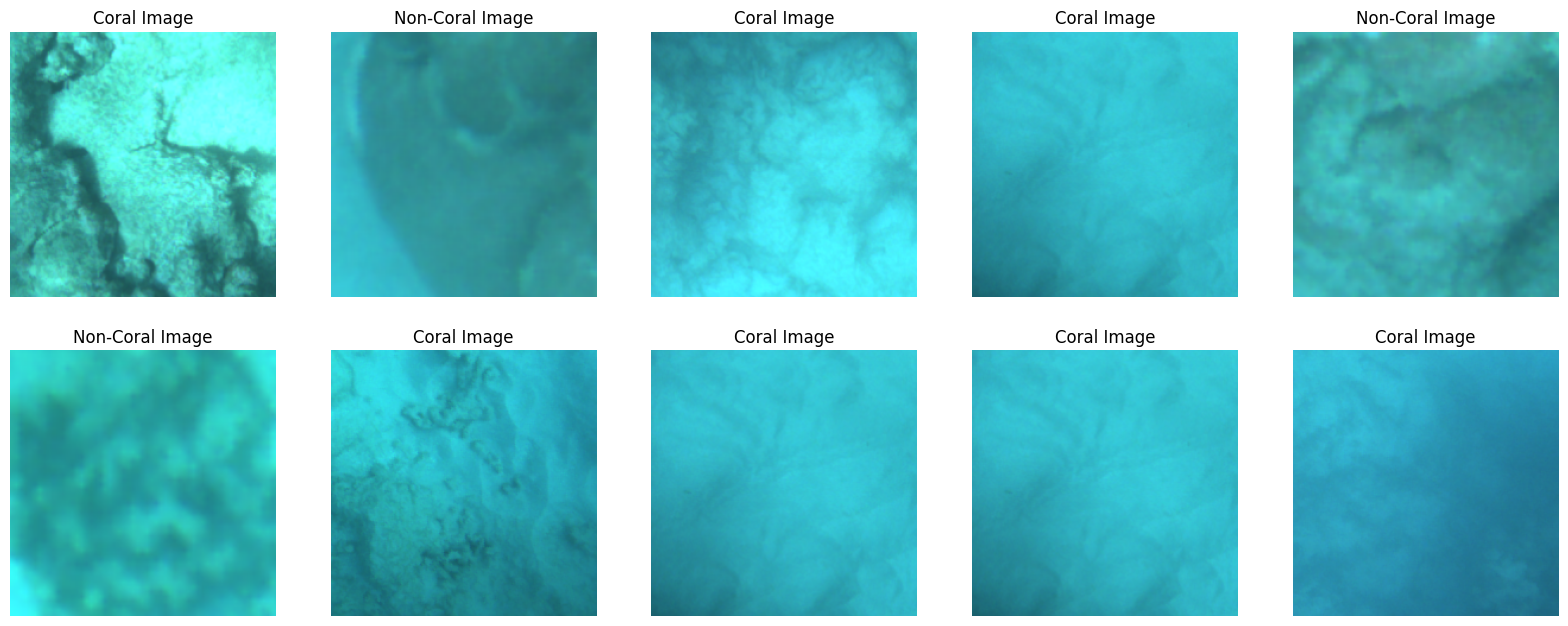

In [22]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(batch),10))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(batch[i].T)
    plt.title(functionlabel(labels[i]))
    plt.axis('off')     
plt.show()

## Labels

In [23]:
y_train = np.array([y for x, y in iter(traindata)])
y_test = np.array([y for x, y in iter(testdata)])
y_val = np.array([y for x, y in iter(valdata)])

## Training Count

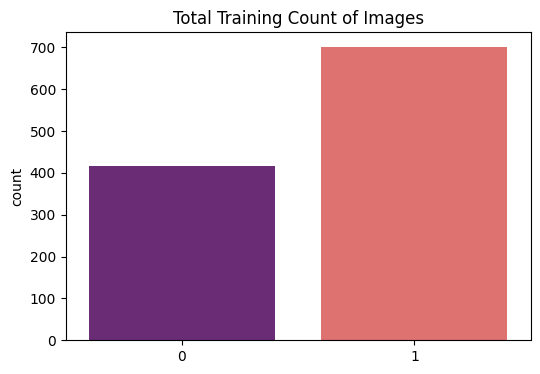

In [24]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Training Count of Images')
sns.countplot(x = y_train, palette = 'magma')
plt.show()

## Test Count

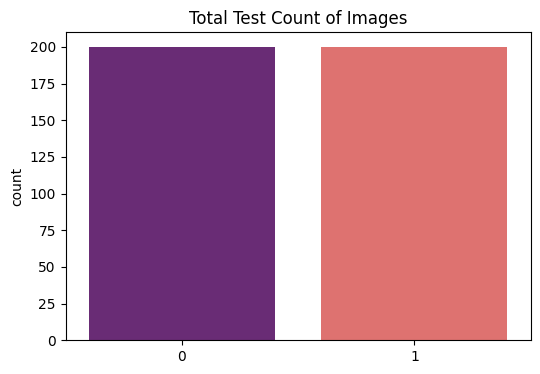

In [25]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Test Count of Images')
sns.countplot(x = y_test, palette = 'magma')
plt.show()

## Creating ResNet50

In [26]:
resnet = models.resnet50(pretrained=True).to(cuda0)

## Closing Final Layer

In [27]:
for param in resnet.parameters():
    param.requires_grad = False

## Extract Features

In [29]:
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(cuda0)

## Extract Training Features

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [49]:
train_features = []
train_labels = []
for inputs, labels in X_trian:
    inputs = inputs.to(cuda0)
    outputs = resnet(inputs)
    features = outputs.view(inputs.size(0), -1).detach().cpu().numpy()
    features = features.reshape(inputs.size(0), -1)
    train_features.append(features)
    train_labels.append(labels)

## Extract Test Features

In [50]:
test_features = []
test_labels = []
for inputs, labels in X_test:
    inputs = inputs.to(cuda0)
    outputs = resnet(inputs)
    features = outputs.view(inputs.size(0), -1).detach().cpu().numpy()
    features = features.reshape(inputs.size(0), -1)
    test_features.append(features)
    test_labels.append(labels)

## Train Linear Regression

In [81]:
lfc = LogisticRegression()
lfc.fit(np.concatenate(train_features), np.concatenate(train_labels))

LogisticRegression()

## Model Accuracy

In [82]:
test_pred = lfc.predict(np.concatenate(test_features))
test_acc = accuracy_score(np.concatenate(test_labels), test_pred)
print("Test Accuracy: {:.4f}".format(test_acc))

Test Accuracy: 0.9375


## Evaluation Metric for Test Data



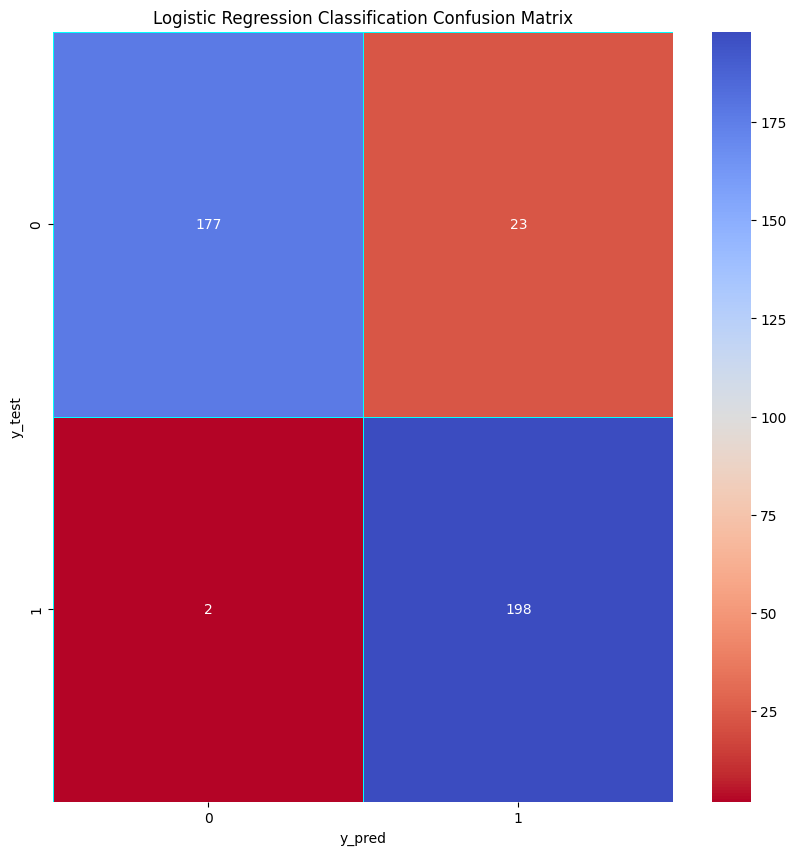

In [83]:
# Creating the confusion matrix:
e_cm = confusion_matrix(np.concatenate(test_labels), test_pred)
# Visualization:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(e_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='coolwarm_r')
plt.title('Logistic Regression Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [84]:
print(classification_report(np.concatenate(test_labels), test_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93       200
           1       0.90      0.99      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



## KNN

In [85]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(np.concatenate(train_features), np.concatenate(train_labels))

KNeighborsClassifier()

## Model Accuracy

In [86]:
test_pred = neigh.predict(np.concatenate(test_features))
test_acc = accuracy_score(np.concatenate(test_labels), test_pred)
print("Test Accuracy: {:.4f}".format(test_acc))

Test Accuracy: 0.9250


## Evaluation Metric for Test Data



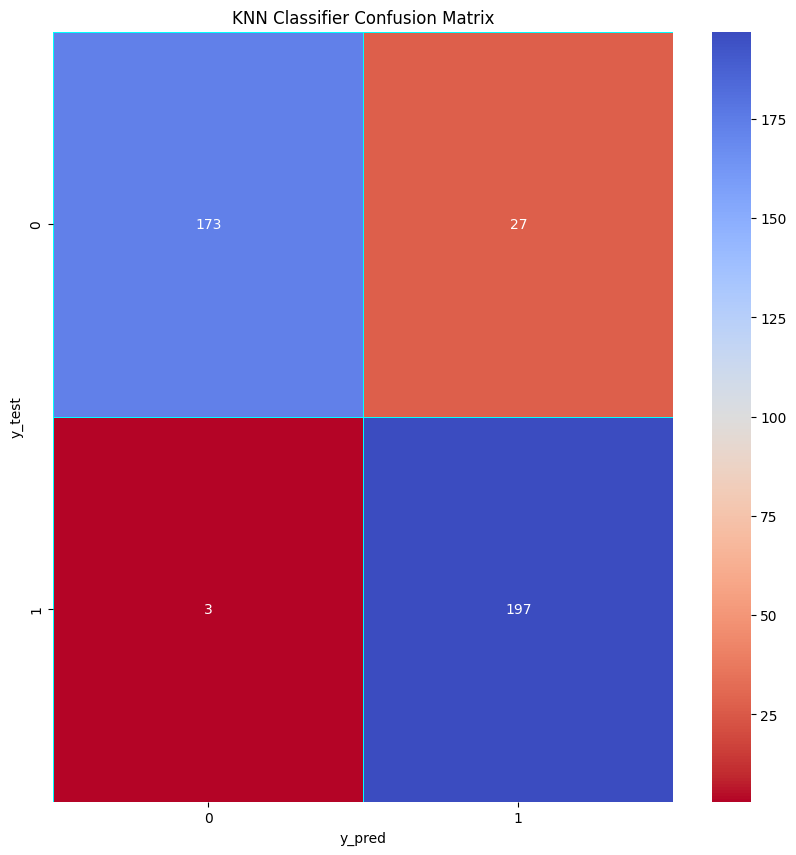

In [88]:
# Creating the confusion matrix:
e_cm = confusion_matrix(np.concatenate(test_labels), test_pred)
# Visualization:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(e_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='coolwarm_r')
plt.title('KNN Classifier Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [89]:
print(classification_report(np.concatenate(test_labels), test_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       200
           1       0.88      0.98      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400



## Random Forest

In [90]:
rfc = RandomForestClassifier(random_state=32)
rfc.fit(np.concatenate(train_features), np.concatenate(train_labels))

RandomForestClassifier(random_state=32)

## Model Accuracy

In [91]:
test_pred = rfc.predict(np.concatenate(test_features))
test_acc = accuracy_score(np.concatenate(test_labels), test_pred)
print("Test Accuracy: {:.4f}".format(test_acc))

Test Accuracy: 0.9150


## Evaluation Metric for Test Data



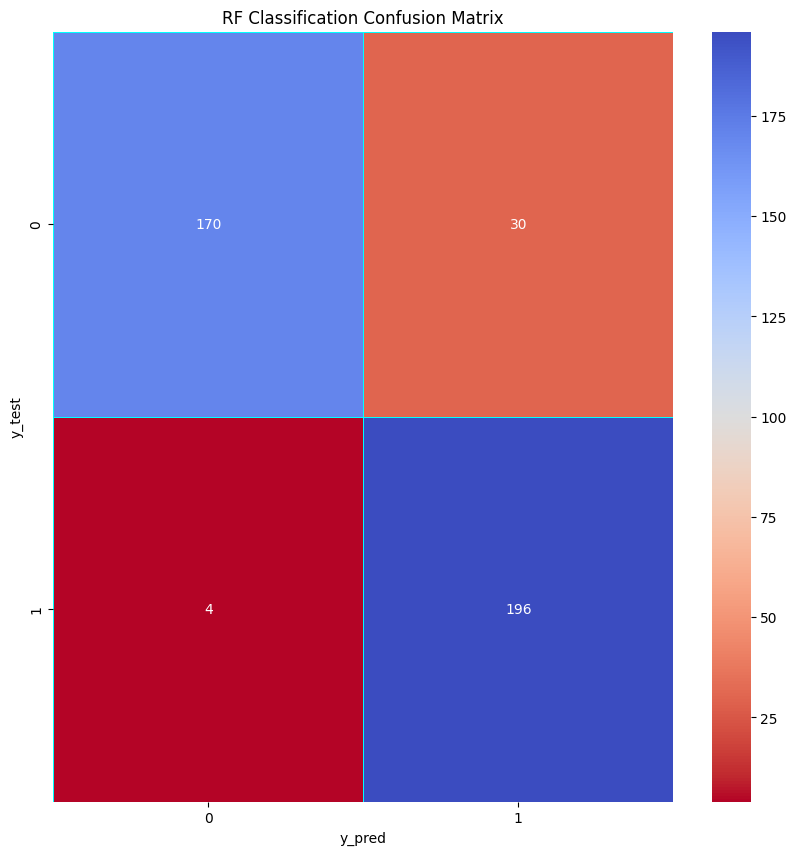

In [92]:
# Creating the confusion matrix:
e_cm = confusion_matrix(np.concatenate(test_labels), test_pred)
# Visualization:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(e_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='coolwarm_r')
plt.title('RF Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [93]:
print(classification_report(np.concatenate(test_labels), test_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       200
           1       0.87      0.98      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.91       400
weighted avg       0.92      0.92      0.91       400

